# Duck vs Chicken Image Classification using Transfer Learning

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report, confusion_matrix
import time
import copy
from google.colab import files, drive
import zipfile
import requests
import gdown
import shutil
import json

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mount Google Drive (if needed)
# drive.mount('/content/drive')

Using device: cuda:0


In [2]:
def download_kaggle_dataset(dataset_name, target_dir='./dataset', kaggle_json_path=None):
    """
    Download any Kaggle dataset with ease.

    Parameters:
    -----------
    dataset_name : str
        The Kaggle dataset name in format 'username/dataset-name'
        Example: 'abhi8923shriv/sentiment-analysis-dataset'
    target_dir : str
        Directory to extract the dataset to (default: './dataset')
    kaggle_json_path : str or None
        Path to kaggle.json credentials file (optional)

    Returns:
    --------
    str
        Path to the extracted dataset
    """
    import os
    import zipfile
    import subprocess
    from google.colab import files

    # Create target directory
    os.makedirs(target_dir, exist_ok=True)
    print(f"Downloading dataset '{dataset_name}' from Kaggle...")

    try:
        # Install kaggle API if not already installed
        subprocess.check_output("pip install -q kaggle", shell=True)

        # Set up kaggle credentials directory
        kaggle_dir = os.path.expanduser('~/.kaggle')
        os.makedirs(kaggle_dir, exist_ok=True)
        os.environ['KAGGLE_CONFIG_DIR'] = kaggle_dir

        # Check if kaggle.json exists at the specified path
        if kaggle_json_path and os.path.exists(kaggle_json_path):
            # Copy kaggle.json to the right location
            subprocess.check_output(f"cp {kaggle_json_path} {kaggle_dir}/kaggle.json", shell=True)
        elif not os.path.exists(f"{kaggle_dir}/kaggle.json"):
            # If no kaggle.json found, ask user to upload it
            print("Kaggle API credentials not found. Please upload your kaggle.json file.")
            uploaded = files.upload()

            if not uploaded:
                raise Exception("No kaggle.json provided. Cannot proceed with download.")

            # Save the uploaded file to the .kaggle directory
            kaggle_json_filename = list(uploaded.keys())[0]
            with open(kaggle_json_filename, 'rb') as f_in:
                with open(f"{kaggle_dir}/kaggle.json", 'wb') as f_out:
                    f_out.write(f_in.read())

        # Set proper permissions for the kaggle.json file
        subprocess.check_output(f"chmod 600 {kaggle_dir}/kaggle.json", shell=True)

        # Verify kaggle credentials work - removed the --quiet flag
        try:
            subprocess.check_output("kaggle datasets list", shell=True, stderr=subprocess.STDOUT)
            print("✓ Kaggle API credentials verified successfully")
        except subprocess.CalledProcessError as e:
            print(f"❌ Kaggle API credentials validation failed: {e.output.decode() if hasattr(e, 'output') else str(e)}")
            # Let's check if the kaggle.json file has valid format
            print("Checking kaggle.json format...")
            try:
                with open(f"{kaggle_dir}/kaggle.json", 'r') as f:
                    import json
                    creds = json.load(f)
                    if not ('username' in creds and 'key' in creds):
                        print("❌ kaggle.json file does not contain required 'username' and 'key' fields")
            except Exception as json_err:
                print(f"❌ Could not parse kaggle.json: {json_err}")

            raise Exception("Invalid Kaggle credentials")

        # Download the dataset
        print(f"Downloading dataset: {dataset_name}")
        subprocess.check_output(f"kaggle datasets download -d {dataset_name} --path {target_dir}", shell=True)

        # Find the downloaded zip file
        zip_files = [f for f in os.listdir(target_dir) if f.endswith('.zip')]

        if not zip_files:
            raise Exception("Download successful but no zip file found.")

        # Extract the zip file
        zip_path = os.path.join(target_dir, zip_files[0])
        print(f"Extracting {zip_path}...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(target_dir)

        # Remove the zip file to save space
        os.remove(zip_path)
        print(f"Dataset extracted to {target_dir}")

        return target_dir

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("\nManual download instructions:")
        print(f"1. Go to: https://www.kaggle.com/datasets/{dataset_name}")
        print("2. Click 'Download' button")
        print("3. Upload the downloaded zip file below")

        # Ask user to manually upload the dataset
        print("\nPlease upload the dataset zip file:")
        uploaded = files.upload()

        if not uploaded:
            raise Exception("No dataset provided. Cannot proceed.")

        # Extract uploaded file
        for filename in uploaded.keys():
            if filename.endswith('.zip'):
                print(f"Extracting {filename}...")
                with zipfile.ZipFile(filename, 'r') as zip_ref:
                    zip_ref.extractall(target_dir)
                print(f"Dataset extracted to {target_dir}")
                return target_dir

        raise Exception("Uploaded file is not a zip file.")

In [ ]:
dataset_path = download_kaggle_dataset('roudranildas/chicken-images-classification-dataset', "./chicken_duck_datasets")
dataset_path

Extracting ./chicken_duck_datasets/chicken-images-classification-dataset.zip...
Dataset extracted to ./chicken_duck_datasets


'./chicken_duck_datasets'

In [ ]:
# Define paths according to the dataset structure
base_dir = f'./{dataset_path}/data'
chicken_dir = os.path.join(base_dir, 'chicken-images', 'data')
duck_dir = os.path.join(base_dir, 'duck-images', 'data')

# Function to check if directories exist and display image counts
def check_dataset():
    splits = ['train', 'val', 'test']
    dataset_info = {}

    # Check chicken images
    for split in splits:
        chicken_split_dir = os.path.join(chicken_dir, split)
        if os.path.exists(chicken_split_dir):
            chicken_files = [f for f in os.listdir(chicken_split_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
            dataset_info[f'chicken_{split}'] = len(chicken_files)
        else:
            dataset_info[f'chicken_{split}'] = 0
            print(f"Warning: {chicken_split_dir} does not exist.")

    # Check duck images
    for split in splits:
        duck_split_dir = os.path.join(duck_dir, split)
        if os.path.exists(duck_split_dir):
            duck_files = [f for f in os.listdir(duck_split_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
            dataset_info[f'duck_{split}'] = len(duck_files)
        else:
            dataset_info[f'duck_{split}'] = 0
            print(f"Warning: {duck_split_dir} does not exist.")

    # Print summary
    print("\nDataset Summary:")
    for split in splits:
        print(f"{split.capitalize()} set: {dataset_info[f'chicken_{split}']} chicken images, {dataset_info[f'duck_{split}']} duck images")

    return dataset_info

# Check dataset structure and content
dataset_info = check_dataset()


Dataset Summary:
Train set: 275 chicken images, 622 duck images
Val set: 52 chicken images, 109 duck images
Test set: 172 chicken images, 310 duck images


In [ ]:
# Create a unified directory structure for PyTorch ImageFolder
unified_data_dir = './chicken_duck_unified_data'
train_dir = os.path.join(unified_data_dir, 'train')
val_dir = os.path.join(unified_data_dir, 'val')
test_dir = os.path.join(unified_data_dir, 'test')

# Create class directories in each split
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)
    os.makedirs(os.path.join(dir_path, 'chicken'), exist_ok=True)
    os.makedirs(os.path.join(dir_path, 'duck'), exist_ok=True)

# Function to copy images from original structure to unified structure
def organize_dataset():
    # Process chicken images
    for split in ['train', 'val', 'test']:
        src_chicken = os.path.join(chicken_dir, split)
        dst_chicken = os.path.join(unified_data_dir, split, 'chicken')

        if os.path.exists(src_chicken):
            chicken_files = [f for f in os.listdir(src_chicken) if f.endswith(('.jpg', '.jpeg', '.png'))]
            for file in chicken_files:
                src_file = os.path.join(src_chicken, file)
                dst_file = os.path.join(dst_chicken, file)
                shutil.copy(src_file, dst_file)
            print(f"Copied {len(chicken_files)} chicken images to {dst_chicken}")

    # Process duck images
    for split in ['train', 'val', 'test']:
        src_duck = os.path.join(duck_dir, split)
        dst_duck = os.path.join(unified_data_dir, split, 'duck')

        if os.path.exists(src_duck):
            duck_files = [f for f in os.listdir(src_duck) if f.endswith(('.jpg', '.jpeg', '.png'))]
            for file in duck_files:
                src_file = os.path.join(src_duck, file)
                dst_file = os.path.join(dst_duck, file)
                shutil.copy(src_file, dst_file)
            print(f"Copied {len(duck_files)} duck images to {dst_duck}")

# Organize the dataset
organize_dataset()

Copied 275 chicken images to ./chicken_duck_unified_data/train/chicken
Copied 52 chicken images to ./chicken_duck_unified_data/val/chicken
Copied 172 chicken images to ./chicken_duck_unified_data/test/chicken
Copied 622 duck images to ./chicken_duck_unified_data/train/duck
Copied 109 duck images to ./chicken_duck_unified_data/val/duck
Copied 310 duck images to ./chicken_duck_unified_data/test/duck


Classes: ['chicken', 'duck']
Train images: 897
Val images: 161
Test images: 482


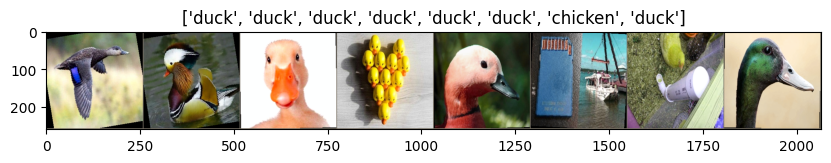

In [ ]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

# Create dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=8, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=8, shuffle=False, num_workers=2),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=8, shuffle=False, num_workers=2)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
for split in ['train', 'val', 'test']:
    print(f"{split.capitalize()} images: {dataset_sizes[split]}")

# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(10, 8))
imshow(out, title=[class_names[x] for x in classes])
plt.show()

Epoch 1/15
----------
train Loss: 0.5823 Acc: 0.6756
val Loss: 0.4876 Acc: 0.7640

Classification Report:
              precision    recall  f1-score   support

     chicken       1.00      0.27      0.42        52
        duck       0.74      1.00      0.85       109

    accuracy                           0.76       161
   macro avg       0.87      0.63      0.64       161
weighted avg       0.82      0.76      0.71       161



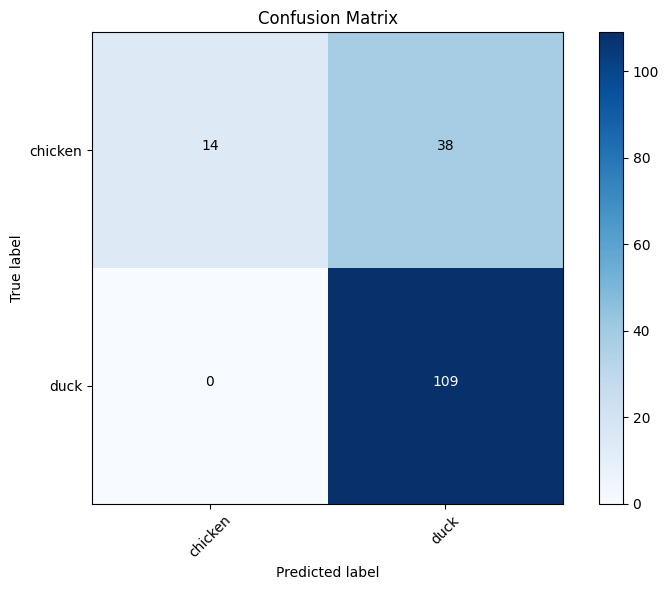


Epoch 2/15
----------
train Loss: 0.3943 Acc: 0.8205
val Loss: 0.3427 Acc: 0.8571

Classification Report:
              precision    recall  f1-score   support

     chicken       1.00      0.56      0.72        52
        duck       0.83      1.00      0.90       109

    accuracy                           0.86       161
   macro avg       0.91      0.78      0.81       161
weighted avg       0.88      0.86      0.84       161



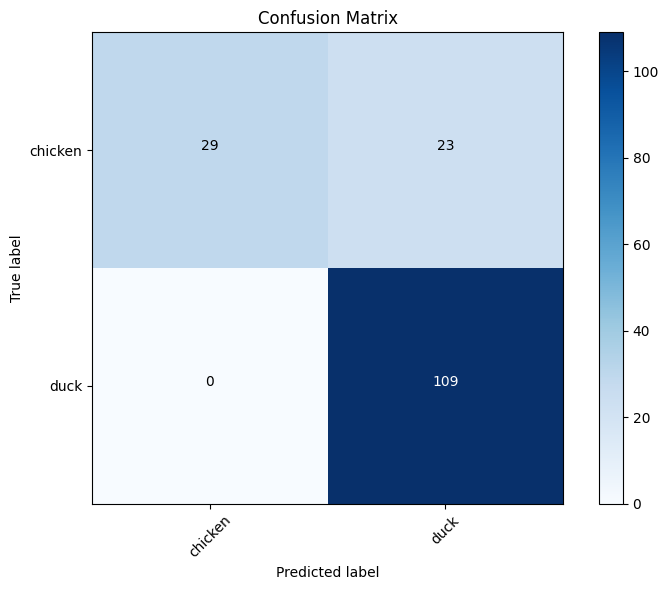


Epoch 3/15
----------
train Loss: 0.2605 Acc: 0.9197
val Loss: 0.2195 Acc: 0.9130

Classification Report:
              precision    recall  f1-score   support

     chicken       1.00      0.73      0.84        52
        duck       0.89      1.00      0.94       109

    accuracy                           0.91       161
   macro avg       0.94      0.87      0.89       161
weighted avg       0.92      0.91      0.91       161



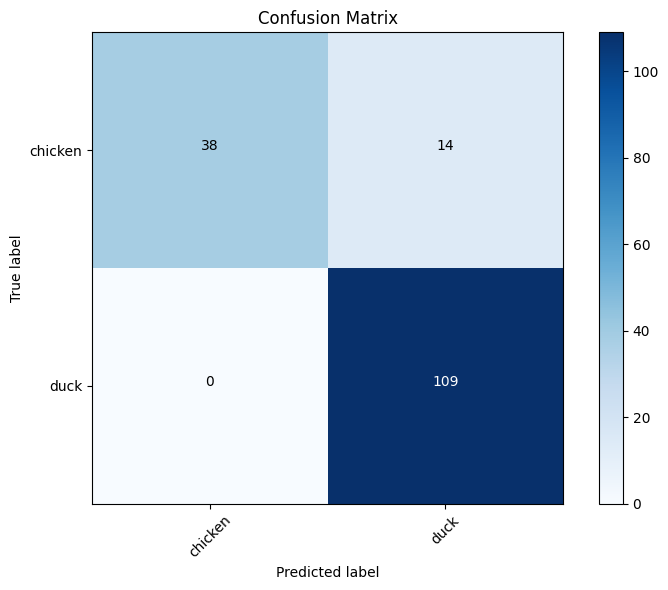


Epoch 4/15
----------
train Loss: 0.1907 Acc: 0.9409
val Loss: 0.1876 Acc: 0.9379

Classification Report:
              precision    recall  f1-score   support

     chicken       1.00      0.81      0.89        52
        duck       0.92      1.00      0.96       109

    accuracy                           0.94       161
   macro avg       0.96      0.90      0.92       161
weighted avg       0.94      0.94      0.94       161



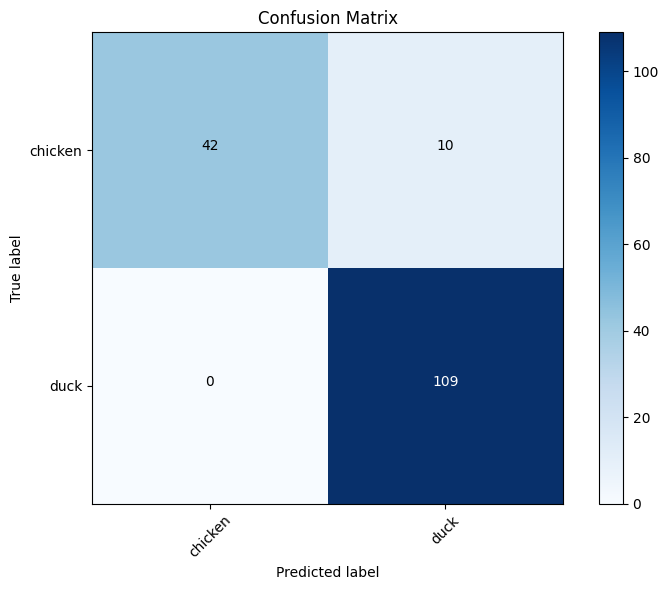


Epoch 5/15
----------
train Loss: 0.1604 Acc: 0.9498
val Loss: 0.1609 Acc: 0.9317

Epoch 6/15
----------
train Loss: 0.1436 Acc: 0.9476
val Loss: 0.1397 Acc: 0.9317

Epoch 7/15
----------
train Loss: 0.1285 Acc: 0.9543
val Loss: 0.1508 Acc: 0.9379

Epoch 8/15
----------
train Loss: 0.1216 Acc: 0.9532
val Loss: 0.1519 Acc: 0.9193

Epoch 9/15
----------
train Loss: 0.1164 Acc: 0.9621
val Loss: 0.1363 Acc: 0.9441

Classification Report:
              precision    recall  f1-score   support

     chicken       1.00      0.83      0.91        52
        duck       0.92      1.00      0.96       109

    accuracy                           0.94       161
   macro avg       0.96      0.91      0.93       161
weighted avg       0.95      0.94      0.94       161



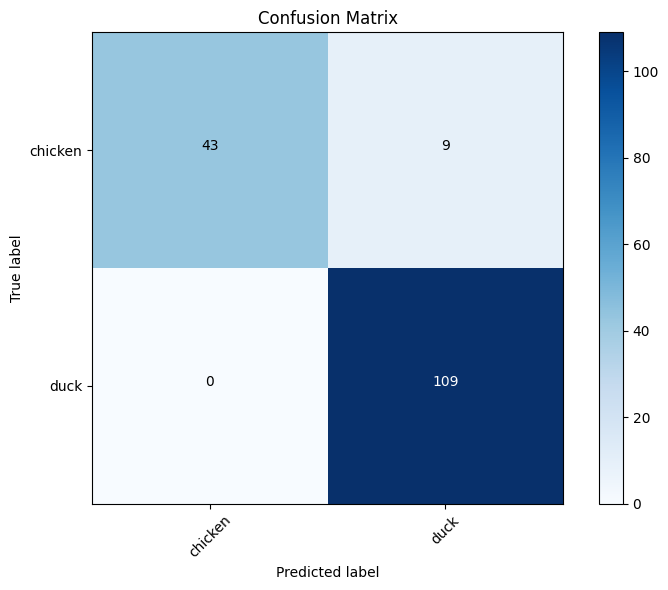


Epoch 10/15
----------
train Loss: 0.1200 Acc: 0.9576
val Loss: 0.1611 Acc: 0.9317

Epoch 11/15
----------
train Loss: 0.1251 Acc: 0.9543
val Loss: 0.1406 Acc: 0.9379

Epoch 12/15
----------
train Loss: 0.1084 Acc: 0.9666
val Loss: 0.1477 Acc: 0.9317

Epoch 13/15
----------
train Loss: 0.1096 Acc: 0.9599
val Loss: 0.1764 Acc: 0.9068

Epoch 14/15
----------
train Loss: 0.1034 Acc: 0.9666
val Loss: 0.1276 Acc: 0.9379

Epoch 15/15
----------
train Loss: 0.1136 Acc: 0.9599
val Loss: 0.1373 Acc: 0.9379

Training complete in 2m 29s
Best val Acc: 0.9441


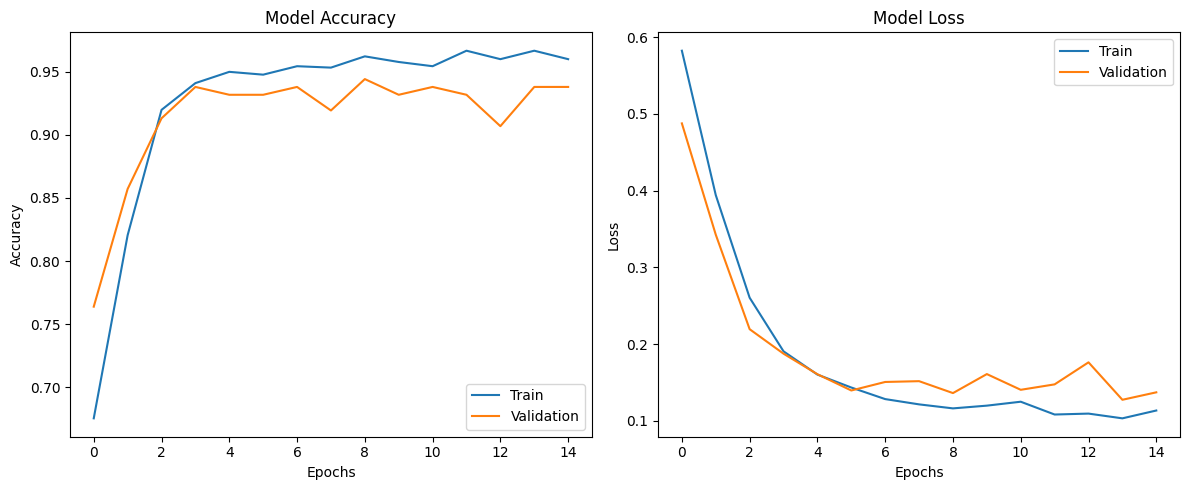

In [ ]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # For tracking metrics
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Collect predictions and labels for classification report
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            if phase == 'train' and scheduler:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu().numpy())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu().numpy())

            # If we got a better model on validation data, save it
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # Generate classification report for best model
                print("\nClassification Report:")
                print(classification_report(all_labels, all_preds, target_names=class_names))

                # Generate confusion matrix
                cm = confusion_matrix(all_labels, all_preds)
                plt.figure(figsize=(8, 6))
                plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
                plt.title('Confusion Matrix')
                plt.colorbar()
                tick_marks = np.arange(len(class_names))
                plt.xticks(tick_marks, class_names, rotation=45)
                plt.yticks(tick_marks, class_names)

                # Add text annotations to confusion matrix
                thresh = cm.max() / 2.
                for i in range(cm.shape[0]):
                    for j in range(cm.shape[1]):
                        plt.text(j, i, format(cm[i, j], 'd'),
                                horizontalalignment="center",
                                color="white" if cm[i, j] > thresh else "black")

                plt.ylabel('True label')
                plt.xlabel('Predicted label')
                plt.tight_layout()
                plt.show()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Plot training and validation accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Train')
    plt.plot(val_acc_history, label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train')
    plt.plot(val_loss_history, label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Load a pre-trained model and reset final fully connected layer
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all layers except the last few
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the classifier
num_ftrs = model.fc.in_features

# Replace the final layer for our binary classification task
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)  # 2 classes: duck and chicken
)

model = model.to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

In [ ]:
# Function to test on individual images
def test_image(image_path):
    img = torchvision.io.read_image(image_path).float() / 255
    # Apply same transforms as validation
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, 1)

    # Display image
    plt.figure()
    plt.imshow(torchvision.io.read_image(image_path).permute(1, 2, 0) / 255)
    plt.title(f'Predicted: {class_names[preds.item()]}')
    plt.axis('off')
    plt.show()

    return class_names[preds.item()]

# Save the model
torch.save(model.state_dict(), 'duck_chicken_classifier.pth')
print("Model saved as 'duck_chicken_classifier.pth'")

Model saved as 'duck_chicken_classifier.pth'



Evaluating model on test set...

Test Set Accuracy: 0.9606

Classification Report:
              precision    recall  f1-score   support

     chicken       0.99      0.90      0.94       172
        duck       0.94      1.00      0.97       310

    accuracy                           0.96       482
   macro avg       0.97      0.95      0.96       482
weighted avg       0.96      0.96      0.96       482



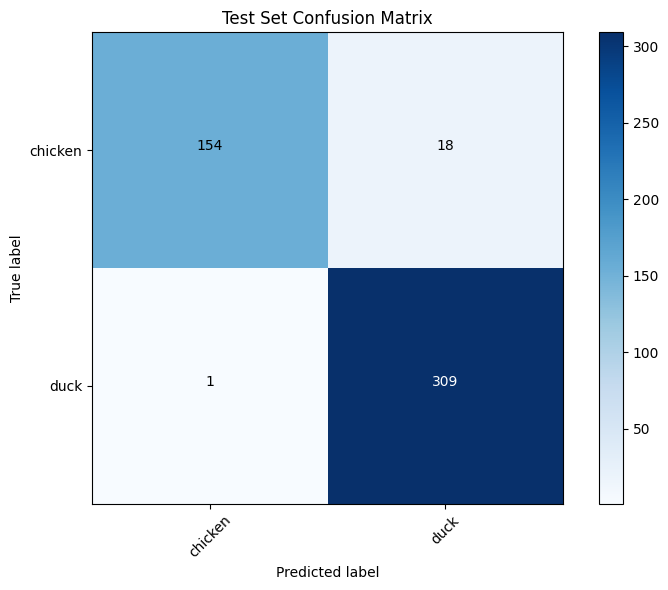

In [ ]:
# Final evaluation on test data
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

    print(f"\nTest Set Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Test Set Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    return accuracy, all_preds, all_labels

# Evaluate on test set
print("\nEvaluating model on test set...")
test_accuracy, test_preds, test_labels = evaluate_model(model, dataloaders['test'])


Visualizing predictions on balanced test data...


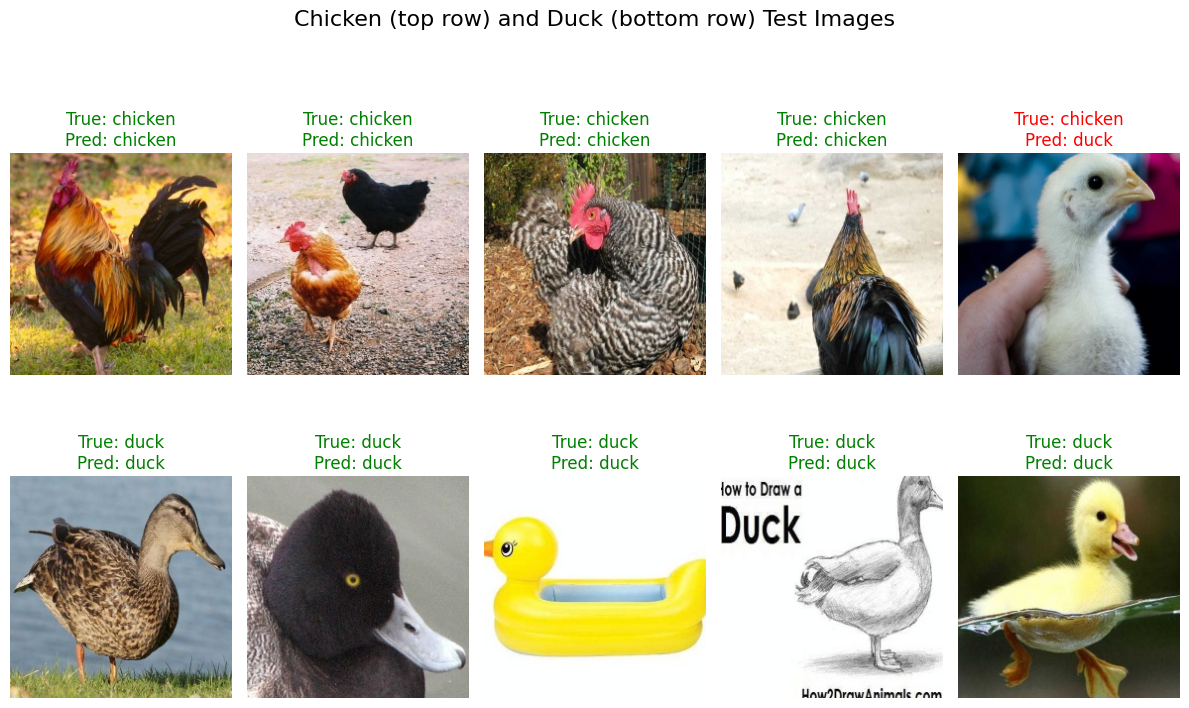

In [ ]:
def visualize_balanced_predictions(model, dataloader, num_per_class=5):
    """
    Visualize predictions on test data with equal number of images per class.

    Args:
        model: The trained model
        dataloader: DataLoader containing test images
        num_per_class: Number of images to show per class
    """
    model.eval()

    # Containers to store images of each class
    chicken_samples = {'inputs': [], 'labels': [], 'preds': []}
    duck_samples = {'inputs': [], 'labels': [], 'preds': []}

    # Collect samples
    with torch.no_grad():
        for inputs, labels in dataloader:
            if (len(chicken_samples['inputs']) >= num_per_class and
                len(duck_samples['inputs']) >= num_per_class):
                break

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Process each image in the batch
            for j in range(inputs.size()[0]):
                # Get class name for this sample
                class_name = class_names[labels[j]]

                # Store chicken samples
                if class_name == 'chicken' and len(chicken_samples['inputs']) < num_per_class:
                    chicken_samples['inputs'].append(inputs[j].cpu())
                    chicken_samples['labels'].append(labels[j].item())
                    chicken_samples['preds'].append(preds[j].item())

                # Store duck samples
                elif class_name == 'duck' and len(duck_samples['inputs']) < num_per_class:
                    duck_samples['inputs'].append(inputs[j].cpu())
                    duck_samples['labels'].append(labels[j].item())
                    duck_samples['preds'].append(preds[j].item())

    # Plot the results
    fig = plt.figure(figsize=(12, 8))
    total_samples = num_per_class * 2

    # Plot chicken samples
    for i in range(len(chicken_samples['inputs'])):
        ax = plt.subplot(2, num_per_class, i + 1)

        # Display image
        img = chicken_samples['inputs'][i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.imshow(img)

        # Add title with prediction
        pred_class = class_names[chicken_samples['preds'][i]]
        true_class = class_names[chicken_samples['labels'][i]]
        title = f"True: {true_class}\nPred: {pred_class}"

        # Color code (green if correct, red if wrong)
        color = 'green' if pred_class == true_class else 'red'
        ax.set_title(title, color=color)
        ax.axis('off')

    # Plot duck samples
    for i in range(len(duck_samples['inputs'])):
        ax = plt.subplot(2, num_per_class, num_per_class + i + 1)

        # Display image
        img = duck_samples['inputs'][i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.imshow(img)

        # Add title with prediction
        pred_class = class_names[duck_samples['preds'][i]]
        true_class = class_names[duck_samples['labels'][i]]
        title = f"True: {true_class}\nPred: {pred_class}"

        # Color code (green if correct, red if wrong)
        color = 'green' if pred_class == true_class else 'red'
        ax.set_title(title, color=color)
        ax.axis('off')

    plt.suptitle("Chicken (top row) and Duck (bottom row) Test Images", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call the function
print("\nVisualizing predictions on balanced test data...")
visualize_balanced_predictions(model, dataloaders['test'], num_per_class=5)

# 2. Transfer Learning for text data using Transformer

In [3]:
import chardet
import pandas as pd
import numpy as np
import os
import subprocess
from sklearn.metrics import classification_report
from google.colab import files, drive
# from datasets import Dataset
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import os

In [4]:
dataset_path = download_kaggle_dataset('abhi8923shriv/sentiment-analysis-dataset', "./sentiment_datasets")
dataset_path

Kaggle API credentials not found. Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
✓ Kaggle API credentials verified successfully
Extracting ./sentiment_datasets/sentiment-analysis-dataset.zip...
Dataset extracted to ./sentiment_datasets


'./sentiment_datasets'

In [21]:
# Function to detect file encoding
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

# 1. Load the dataset with proper encoding
def load_csv_with_encoding(file_path):
    try:
        # Try common encodings first
        for encoding in ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']:
            try:
                return pd.read_csv(file_path, encoding=encoding)
            except UnicodeDecodeError:
                continue

        # Detect encoding if common ones fail
        detected_encoding = detect_encoding(file_path)
        return pd.read_csv(file_path, encoding=detected_encoding)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Load the datasets
train_path = './sentiment_datasets/train.csv'
test_path = './sentiment_datasets/test.csv'

train_df = load_csv_with_encoding(train_path)
test_df = load_csv_with_encoding(test_path)

if train_df is None or test_df is None:
    raise ValueError("Could not load dataset files. Please check file paths and formats.")

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Display the first few rows to inspect column names
print("\nTraining data sample:")
train_df.head()

Training data shape: (27481, 10)
Test data shape: (4815, 9)

Training data sample:


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26



Missing values in training data:
text         1
sentiment    0
dtype: int64

Missing values in test data:
text         1281
sentiment    1281
dtype: int64


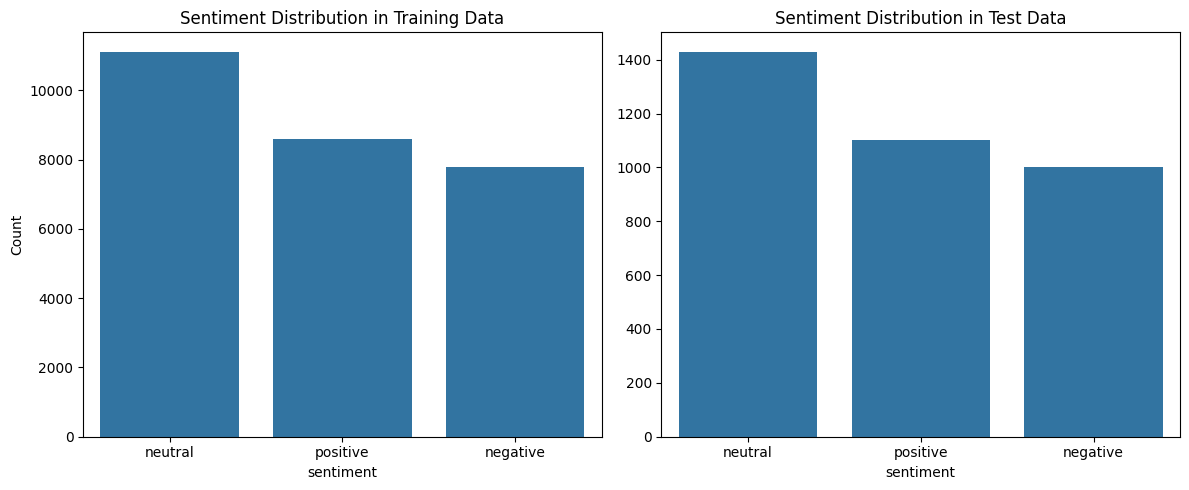

In [22]:
# Check for missing values
print("\nMissing values in training data:")
print(train_df[['text', 'sentiment']].isnull().sum())
print("\nMissing values in test data:")
print(test_df[['text', 'sentiment']].isnull().sum())

# Remove rows with missing values in critical columns
train_df = train_df.dropna(subset=['text', 'sentiment'])
test_df = test_df.dropna(subset=['text', 'sentiment'])

# Distribution of sentiment classes
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_sentiment_counts = train_df['sentiment'].value_counts()
sns.barplot(x=train_sentiment_counts.index, y=train_sentiment_counts.values)
plt.title('Sentiment Distribution in Training Data')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
test_sentiment_counts = test_df['sentiment'].value_counts()
sns.barplot(x=test_sentiment_counts.index, y=test_sentiment_counts.values)
plt.title('Sentiment Distribution in Test Data')
plt.tight_layout()
plt.show()


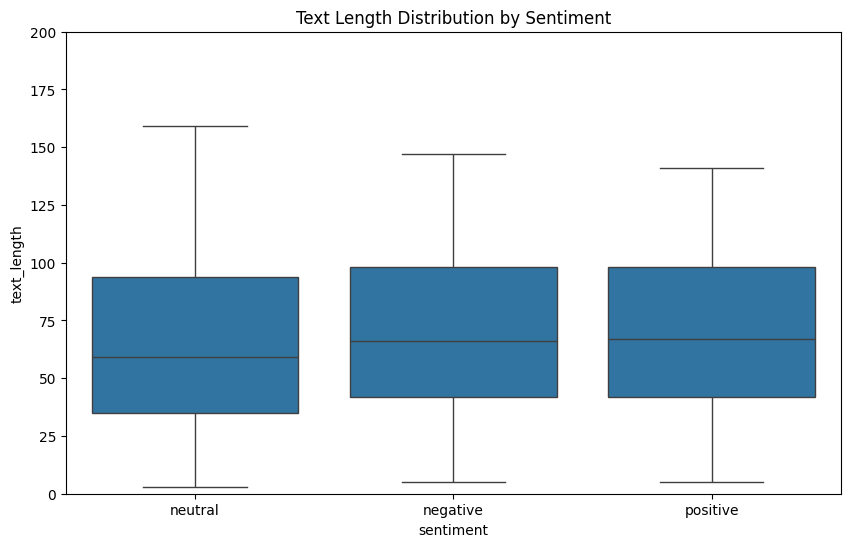


Text Length Stats in Training Data:
- Longest text length: 159
- Shortest text length: 3
- Average text length: 68.35


In [20]:
# Text length distribution by sentiment
train_df['text_length'] = train_df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='text_length', data=train_df)
plt.title('Text Length Distribution by Sentiment')
plt.ylim(0, 200)
plt.show()

# Display longest, shortest, and average text lengths
max_len = train_df['text_length'].max()
min_len = train_df['text_length'].min()
avg_len = train_df['text_length'].mean()
print(f"\nText Length Stats in Training Data:")
print(f"- Longest text length: {max_len}")
print(f"- Shortest text length: {min_len}")
print(f"- Average text length: {avg_len:.2f}")

In [19]:
# Show a few examples from each sentiment class
print("\nExample texts from each sentiment:")
for sentiment in ['positive', 'neutral', 'negative']:
    print(f"\n{sentiment.upper()} examples:")
    for i, row in train_df[train_df['sentiment'] == sentiment].head(3).iterrows():
        print(f"- {row['text']}")


Example texts from each sentiment:

POSITIVE examples:
- 2am feedings for the baby are fun when he is all smiles and coos
-  Journey!? Wow... u just became cooler.  hehe... (is that possible!?)
- I really really like the song Love Story by Taylor Swift

NEUTRAL examples:
-  I`d have responded, if I were going
- http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth
- Soooo high

NEGATIVE examples:
-  Sooo SAD I will miss you here in San Diego!!!
- my boss is bullying me...
-  what interview! leave me alone


In [10]:
# Define label mapping
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}

# Convert string labels to integers
train_df['label'] = train_df['sentiment'].map(label_mapping)
test_df['label'] = test_df['sentiment'].map(label_mapping)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 180  # Maximum sequence length

# Tokenize the text data
def tokenize_data(texts, labels):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))

    return dataset

# Create training and test datasets
train_dataset = tokenize_data(train_df['text'], train_df['label'])
test_dataset = tokenize_data(test_df['text'], test_df['label'])

# Set batch size
batch_size = 256
train_dataset = train_dataset.shuffle(1000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [11]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load pre-trained BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Implement correct layer freezing strategy
# Freeze the embeddings
model.bert.embeddings.trainable = False

# Freeze the first 10 encoder layers (out of 12)
for i in range(10):
    model.bert.encoder.layer[i].trainable = False

# Count trainable vs. non-trainable parameters
trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_variables])
total_params = trainable_params + non_trainable_params

print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")
print(f"Non-trainable parameters: {non_trainable_params:,} ({non_trainable_params/total_params:.2%})")
print(f"Total parameters: {total_params:,}")

# Print model architecture summary
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 14,768,643 (13.49%)
Non-trainable parameters: 94,715,904 (86.51%)
Total parameters: 109,484,547
Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 14768643 (56.34 MB)
Non-trainable params: 94715904 (361.31 MB)
_________________________________________________________________


Epoch 1/5
108/108 [==============================] - 504s 5s/step - loss: 0.5745 - accuracy: 0.7584 - val_loss: 0.5462 - val_accuracy: 0.7748
Epoch 2/5
108/108 [==============================] - 485s 4s/step - loss: 0.5112 - accuracy: 0.7886 - val_loss: 0.5323 - val_accuracy: 0.7875
Epoch 3/5
108/108 [==============================] - 484s 4s/step - loss: 0.4592 - accuracy: 0.8107 - val_loss: 0.5416 - val_accuracy: 0.7799
Epoch 4/5
108/108 [==============================] - 485s 4s/step - loss: 0.4013 - accuracy: 0.8384 - val_loss: 0.5540 - val_accuracy: 0.7852
Epoch 5/5
108/108 [==============================] - 484s 4s/step - loss: 0.3325 - accuracy: 0.8679 - val_loss: 0.6251 - val_accuracy: 0.7705


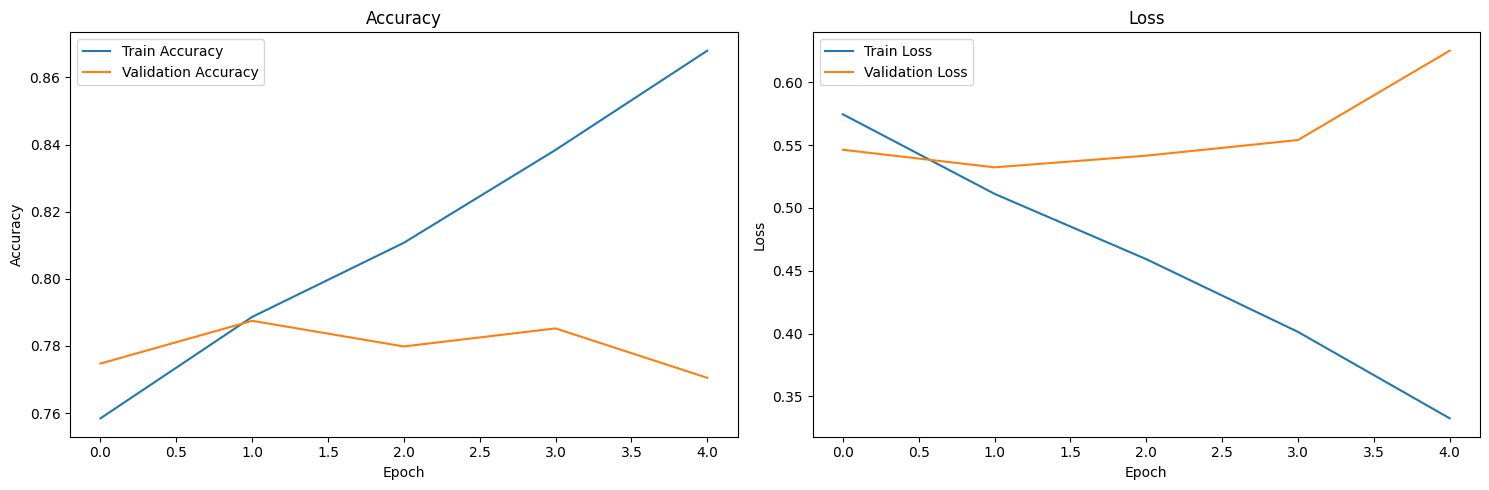

In [14]:
# Define learning rate scheduler
initial_learning_rate = 2e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Set up tensorboard for monitoring
log_dir = "./logs/sentiment_analysis/" + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
epochs = 5
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[early_stopping, tensorboard_callback]
)

# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Plot loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

14/14 [==============================] - 41s 3s/step - loss: 0.5323 - accuracy: 0.7875

Test Loss: 0.5323
Test Accuracy: 0.7875

Classification Report:
              precision    recall  f1-score   support

    positive       0.84      0.80      0.82      1103
     neutral       0.74      0.78      0.76      1430
    negative       0.80      0.79      0.79      1001

    accuracy                           0.79      3534
   macro avg       0.79      0.79      0.79      3534
weighted avg       0.79      0.79      0.79      3534



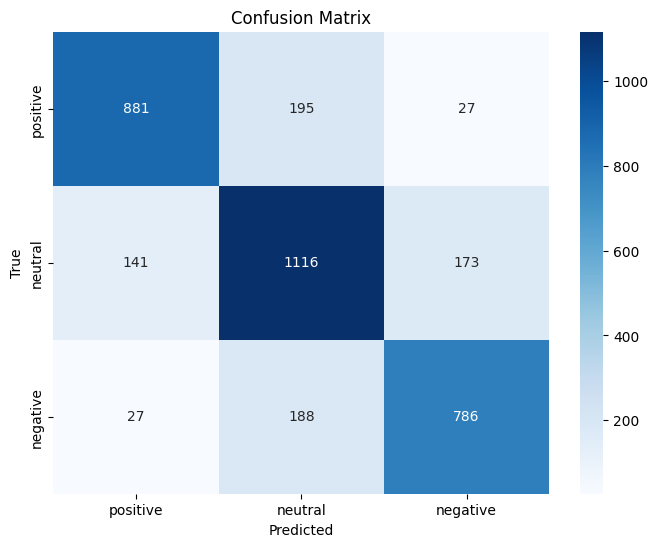


Model saved locally to ./models/sentiment_analysis_bert


In [15]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
all_predictions = []
all_labels = []

for batch in test_dataset:
    inputs, labels = batch
    logits = model(inputs).logits
    predictions = tf.argmax(logits, axis=1)
    all_predictions.extend(predictions.numpy())
    all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Print classification report
target_names = ['positive', 'neutral', 'negative']
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=target_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model locally first
save_dir = "./models/sentiment_analysis_bert"
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"\nModel saved locally to {save_dir}")

In [16]:
# Save the model to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create directory in Google Drive
drive_save_dir = "/content/drive/MyDrive/sentiment_analysis_bert"
os.makedirs(drive_save_dir, exist_ok=True)

# Copy model files to Google Drive
!cp -r {save_dir}/* {drive_save_dir}/
print(f"\nModel saved to Google Drive at {drive_save_dir}")

Mounted at /content/drive

Model saved to Google Drive at /content/drive/MyDrive/sentiment_analysis_bert


In [17]:
# Load the model back from Google Drive
from transformers import TFBertForSequenceClassification, BertTokenizer

loaded_model_dir = "/content/drive/MyDrive/sentiment_analysis_bert"
loaded_model = TFBertForSequenceClassification.from_pretrained(loaded_model_dir)
loaded_tokenizer = BertTokenizer.from_pretrained(loaded_model_dir)

print("Model successfully loaded from Google Drive!")

# Test the loaded model on a few examples
test_texts = [
    "I really enjoyed this movie, it was fantastic!",
    "The product is okay, nothing special about it.",
    "This is the worst experience I've ever had with customer service."
]

# Preprocess the test texts
test_encodings = loaded_tokenizer(
    test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

# Make predictions
logits = loaded_model(test_encodings).logits
predictions = tf.argmax(logits, axis=1).numpy()
probabilities = tf.nn.softmax(logits, axis=1).numpy()

# Map predictions to sentiment labels
sentiment_map = {0: 'positive', 1: 'neutral', 2: 'negative'}
predicted_sentiments = [sentiment_map[pred] for pred in predictions]

# Display results
print("\nModel Prediction Results:")
print("=" * 50)
for i, text in enumerate(test_texts):
    print(f"Text: {text}")
    print(f"Predicted sentiment: {predicted_sentiments[i]}")
    print(f"Confidence scores: Positive: {probabilities[i][0]:.4f}, Neutral: {probabilities[i][1]:.4f}, Negative: {probabilities[i][2]:.4f}")
    print("-" * 50)

# Function to test on a custom input
def predict_sentiment(text):
    # Preprocess the text
    encoding = loaded_tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='tf'
    )

    # Make prediction
    logits = loaded_model(encoding).logits
    prediction = tf.argmax(logits, axis=1).numpy()[0]
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]

    # Map prediction to sentiment label
    sentiment = sentiment_map[prediction]

    return {
        'sentiment': sentiment,
        'confidence': {
            'positive': float(probabilities[0]),
            'neutral': float(probabilities[1]),
            'negative': float(probabilities[2])
        }
    }

# Example of how to use the function
custom_text = "I'm really excited about this new technology!"
result = predict_sentiment(custom_text)
print("\nCustom Text Test:")
print(f"Text: {custom_text}")
print(f"Predicted sentiment: {result['sentiment']}")
print(f"Confidence scores: {result['confidence']}")

Some layers from the model checkpoint at /content/drive/MyDrive/sentiment_analysis_bert were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/sentiment_analysis_bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Model successfully loaded from Google Drive!

Model Prediction Results:
Text: I really enjoyed this movie, it was fantastic!
Predicted sentiment: positive
Confidence scores: Positive: 0.9909, Neutral: 0.0016, Negative: 0.0075
--------------------------------------------------
Text: The product is okay, nothing special about it.
Predicted sentiment: positive
Confidence scores: Positive: 0.5594, Neutral: 0.4273, Negative: 0.0133
--------------------------------------------------
Text: This is the worst experience I've ever had with customer service.
Predicted sentiment: negative
Confidence scores: Positive: 0.0020, Neutral: 0.0054, Negative: 0.9926
--------------------------------------------------

Custom Text Test:
Text: I'm really excited about this new technology!
Predicted sentiment: positive
Confidence scores: {'positive': 0.9959923624992371, 'neutral': 0.002285299589857459, 'negative': 0.0017223076429218054}
